In [ ]:
# 시계열 데이터를 이용해 예측값을 뽑아내는 선형 회귀 모델 생성
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [8]:
# 그래프 그리기 
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# 트렌드
def trend(time, slope=0):
    return slope * time

# 일정 주기로 특정 모양이 나타나는거 == 패턴
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 패턴의 생성 빈도, 강도 등 설정
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# 잡음 생성
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32") # X값)
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series(Y값 생성)
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise(잡음 더하기)
series += noise(time, noise_level, seed=42)

# 시간과 값을 반갈한다
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
# 데이터를 조각조각 나눠주는 함수. window_size 단위로 데이터들을 순차적으로 만든 뒤 window_size크기의 데이터 내에서 또다시 batch_size만큼 묶어준다.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # shift는 데이터를 생성할 때 window_size의 틀?이 몇칸씩 이동하며 window를 만들 것인가 설정하는 변수다. 1이라 함은 한칸씩 이동하며 생성하겠다는 뜻이다.
  # print(dataset) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # 순서 유지? 해준다.
  # print(dataset) 
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # shuffle_buffer만큼 임의로 뽑아 섞은 뒤 뽑은 위치에 다시 갖다놓겠다는 뜻. 데이터가 너무 크면 이렇게 한다. 
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # 데이터셋 완성
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # 모델 생성(정확히는 레이어 생성)
model = tf.keras.models.Sequential([l0]) # 모델 생성


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) # 컴파일
model.fit(dataset,epochs=100,verbose=0) # 훈련

print("Layer weights {}".format(l0.get_weights())) # 가중치가 20개 나온다. 왜냐하면 윈도우 사이즈가 20이었기 때문이다. 20개씩 데이터가 만들어졌고 이를 입력값으로 설정한 결과, 가중치가 20개 생성되어 20개가 출력된다. 


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.01499007],
       [-0.00774261],
       [-0.02386627],
       [-0.00530505],
       [ 0.08260841],
       [-0.02167527],
       [ 0.01806181],
       [-0.04432689],
       [ 0.04912619],
       [-0.02975898],
       [ 0.04178565],
       [-0.08723186],
       [-0.03441558],
       [ 0.09679889],
       [ 0.03559355],
       [ 0.00686099],
       [ 0.10207016],
       [ 0.10650041],
       [ 0.28324693],
       [ 0.44492424]], dtype=float32), array([0.01178654], dtype=float32)]


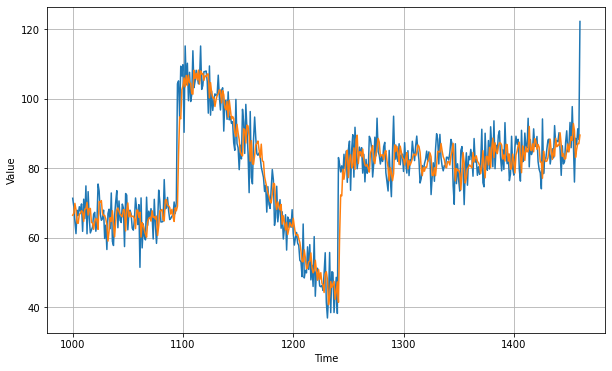

In [13]:
forecast = []

# 예측한거 쌓기
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

# 그래프로 출력. 비슷하게 잘 나온다.
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()